In [10]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import DataGenerator_3d
import time
import warnings

In [2]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [3]:
sequence_length = 10
model = models.get_luke_3d_model2(input_shape=(140,100,1),sequence_length=sequence_length)
warnings.filterwarnings('ignore')
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_train,augment_valid)
params_train['dim']=(sequence_length,140,100)
params_test['dim']=(sequence_length,140,100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
result_val_acc = []

video_path = '/cropped_video100_140'
depth = 10

sequence_length=10 
sample_gap=10 
epochs=30
stepsperepoch=100
k=5

start = time.time()

#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
print(len(control_cells))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
print(len(sus_cells))
#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label     = cnn_module.create_label_dict(sus_cells,1)

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)

train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus
print('train =', len(train_labels))
print('test =', len(test_labels))

im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images_3d(train_labels,test_labels,video_path,sample_gap,depth)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

augment_train, augment_valid = cnn_module.get_augmentations_train_test()

model = models.get_luke_3d_model2(input_shape=(140,100,1),sequence_length=sequence_length)
validate_steps = len(im_paths_test)//32

training_generator = DataGenerator_3d.DataGenerator(im_paths_train, im_labels_train, **params_train,depth=depth)
prediction_generator = DataGenerator_3d.DataGenerator(im_paths_test, im_labels_test, **params_test,depth=depth)

#get kfold predictions from training set 
print('kfold training on train data')
train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, kfold_loss = cnn_module.k_fold_train_3d2(train_labels,video_path,model,sample_gap,epochs,stepsperepoch,params_train,params_test,depth,sequence_length,k)

#fully train a model to make predicitons on the test set
print('final training')
fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
#make the test predictions.
test_preds = cnn_module.predict(test_labels,video_path,fully_train_model,sample_gap,params_test)

run_val_acc = model.history.history['val_acc']
end = time.time()
run_time = end-start
print(run_time)

311
351
train = 594
test = 68
kfold training on train data
all data = 594
kfold 1



Epoch 1/30





100/100 [==============================] - 62s 623ms/step - loss: 0.6921 - acc: 0.5359 - val_loss: 0.6899 - val_acc: 0.6510
Epoch 2/30
100/100 [==============================] - 55s 550ms/step - loss: 0.6913 - acc: 0.5369 - val_loss: 0.6859 - val_acc: 0.5990
Epoch 3/30
100/100 [==============================] - 54s 543ms/step - loss: 0.6903 - acc: 0.5406 - val_loss: 0.6840 - val_acc: 0.6961
Epoch 4/30
100/100 [==============================] - 54s 544ms/step - loss: 0.6874 - acc: 0.5491 - val_loss: 0.6803 - val_acc: 0.5765
Epoch 5/30
100/100 [==============================] - 54s 544ms/step - loss: 0.6874 - acc: 0.5316 - val_loss: 0.6761 - val_acc: 0.7647
Epoch 6/30
100/100 [==============================] - 55s 545ms/step - loss: 0.6852 - acc: 0.5687 - val_loss: 0.6742 - val_acc: 0.6995
Epoch 7/30
100/100 [==============================] - 54s 544ms/step - loss: 0.6837 - acc: 0.5887 - 

In [1]:
# use this cell if the final predictions were bad !
print('final training')
fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
test_preds = cnn_module.predict(test_labels,video_path,fully_train_model,sample_gap,params_test)
run_val_acc = model.history.history['val_acc']

final training


NameError: name 'cnn_module' is not defined

In [8]:
import pickle
results = [test_preds, train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, kfold_loss, run_val_acc]
#pickle.dump(results, open('/home/ubuntu/data/code/chaining/cipro2_chain_3d_results.p','wb'))
## when reloading need to take out of results!!


In [11]:
import pickle
results=pickle.load(open('/home/ubuntu/data/code/chaining/3dchain_preds_final_trim.p','rb'))
kfold_val_acc, kfold_preds, test_val_acc, test_preds = results
#test_preds, train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, kfold_loss = results

In [12]:
# kfold val acc graphs:
#print(kfold_val_acc[i])
averages = np.average(kfold_val_acc, axis=0)
print(averages)

[0.6690361  0.70037558 0.71937639 0.74940764 0.7388662  0.74382688
 0.74615094 0.76743295 0.74957401 0.77854658 0.77203569 0.76100272
 0.77975902 0.7844752  0.78283172 0.77335148 0.77812563 0.76603902
 0.77222474 0.78309639 0.76008268 0.7698906  0.7876588  0.78354255
 0.75578746]


In [8]:
averages = np.average([(np.array(i)[1]) for i in result])
print(averages)

NameError: name 'result' is not defined

25
25


(0.5, 0.85)

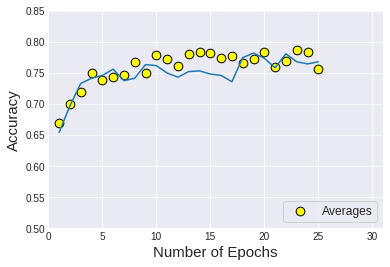

In [13]:
xvals = np.arange(1,26,1)
print(len(xvals))
print(len(averages))

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

plt.scatter(xvals,averages, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
plt.plot(xvals,test_val_acc)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,0.85)

#plt.savefig('/home/ubuntu/data/figs/3dEpochs.png', dpi=500)